<a href="https://colab.research.google.com/github/kareemullah123456789/CNN-AI/blob/main/CNN_CaseStudy_FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Case Study: Fashion-MNIST
## CNN Architecture Design, Data Augmentation & Visualization

---

### Table of Contents
1. Introduction & Dataset Overview
2. Environment Setup
3. Data Loading & Exploration
4. Data Preprocessing
5. Baseline CNN
6. Data Augmentation
7. Improved CNN (BatchNorm + Dropout)
8. Learning Rate Scheduling
9. Filter & Feature Map Visualization
10. Model Comparison
11. Conclusion

---

### Learning Objectives
- Build a **baseline CNN** and understand its components
- Apply **data augmentation** to improve generalization
- Use **BatchNormalization** and **Dropout** for regularization
- Apply **learning rate scheduling** for better convergence
- **Visualize filters and feature maps** to understand what the CNN learns


## 1. Introduction & Dataset Overview

### What is Fashion-MNIST?
Fashion-MNIST is a dataset of **70,000 grayscale images** (28x28 pixels) of clothing items in **10 categories**.

| Property | Value |
|---|---|
| Training images | 60,000 |
| Test images | 10,000 |
| Image size | 28 x 28 x 1 (grayscale) |
| Classes | 10 |

### Classes
| Label | Class |
|---|---|
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

### Why Fashion-MNIST?
- Drop-in replacement for MNIST (same size, same format)
- More challenging than digit MNIST
- Small enough to train quickly on Colab


## 2. Environment Setup


In [1]:
# Check TensorFlow version and GPU availability
import tensorflow as tf  # Import TensorFlow
print(f'TensorFlow version: {tf.__version__}')  # Print version
print(f'GPU available: {tf.config.list_physical_devices("GPU")}')  # Check for GPU


TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# Import all required libraries
import numpy as np                        # For numerical operations
import matplotlib.pyplot as plt            # For plotting graphs
from tensorflow import keras               # High-level Keras API
from tensorflow.keras import layers        # Neural network layers
from tensorflow.keras import models        # Model building
from tensorflow.keras import callbacks     # Training callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Data augmentation
import warnings                            # To suppress warnings
warnings.filterwarnings('ignore')          # Hide unnecessary warnings

# Set random seeds for reproducibility
np.random.seed(42)                         # Numpy random seed
tf.random.set_seed(42)                     # TensorFlow random seed

# Set default plot size
plt.rcParams['figure.figsize'] = (12, 5)   # Width=12, Height=5
plt.rcParams['font.size'] = 11             # Font size for plots
print('All libraries imported.')            # Confirm imports


All libraries imported.


## 3. Data Loading & Exploration


In [3]:
# Load the Fashion-MNIST dataset (built into Keras)
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Define human-readable class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Print dataset information
print(f'Training set: {X_train.shape}')    # (60000, 28, 28)
print(f'Test set:     {X_test.shape}')     # (10000, 28, 28)
print(f'Labels:       {len(class_names)} classes')  # 10 classes
print(f'Pixel range:  [{X_train.min()}, {X_train.max()}]')  # [0, 255]


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training set: (60000, 28, 28)
Test set:     (10000, 28, 28)
Labels:       10 classes
Pixel range:  [0, 255]


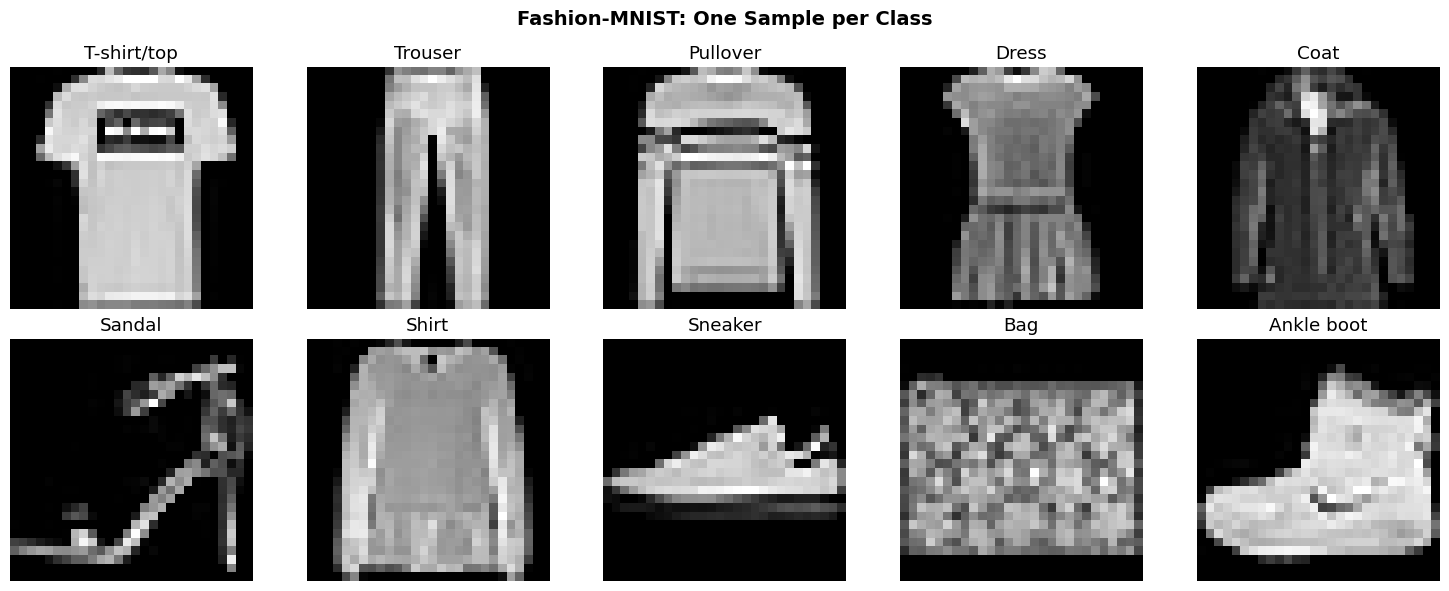

In [4]:
# Show one sample image from each class
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows x 5 columns

for i, ax in enumerate(axes.flat):                 # Loop through all 10 subplots
    idx = np.where(y_train == i)[0][0]             # Find first image of class i
    ax.imshow(X_train[idx], cmap='gray')           # Show image in grayscale
    ax.set_title(class_names[i])                   # Set class name as title
    ax.axis('off')                                 # Hide axis

plt.suptitle('Fashion-MNIST: One Sample per Class', fontsize=14, fontweight='bold')
plt.tight_layout()                                 # Adjust spacing
plt.show()                                         # Display the plot


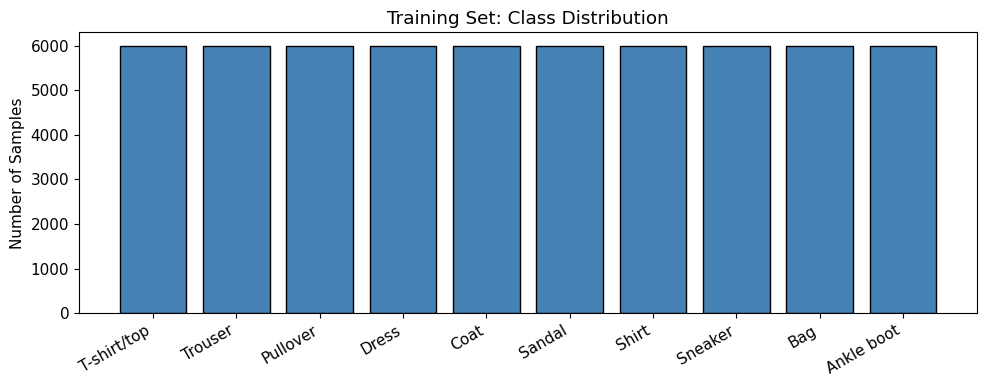

Each class has 6000 samples (balanced dataset)


In [5]:
# Plot the class distribution in training set
unique, counts = np.unique(y_train, return_counts=True)  # Count samples per class

plt.figure(figsize=(10, 4))                        # Set figure size
plt.bar(class_names, counts,                       # Bar chart
        color='steelblue', edgecolor='black')      # Blue bars with black edge
plt.title('Training Set: Class Distribution')      # Title
plt.ylabel('Number of Samples')                    # Y-axis label
plt.xticks(rotation=30, ha='right')                # Rotate x labels
plt.tight_layout()                                 # Adjust spacing
plt.show()                                         # Display
print(f'Each class has {counts[0]} samples (balanced dataset)')  # Confirm balance


## 4. Data Preprocessing

We need to:
1. **Normalize** pixel values from [0, 255] to [0, 1]
2. **Reshape** to add a channel dimension: (28, 28) to (28, 28, 1)
3. **Split** training data into train and validation sets


In [6]:
# Step 1: Normalize pixel values to [0, 1] range
X_train = X_train.astype('float32') / 255.0  # Convert to float and divide by 255
X_test = X_test.astype('float32') / 255.0    # Same for test set

# Step 2: Reshape to add channel dimension (needed for Conv2D)
# Conv2D expects input shape: (batch, height, width, channels)
X_train = X_train.reshape(-1, 28, 28, 1)     # Add channel dim: (60000, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)       # Same for test: (10000, 28, 28, 1)

# Step 3: Create a validation set (last 10000 of training data)
X_val = X_train[-10000:]                      # Last 10000 for validation
y_val = y_train[-10000:]                      # Corresponding labels
X_train_split = X_train[:50000]               # First 50000 for training
y_train_split = y_train[:50000]               # Corresponding labels

print(f'Train: {X_train_split.shape}')        # (50000, 28, 28, 1)
print(f'Val:   {X_val.shape}')                # (10000, 28, 28, 1)
print(f'Test:  {X_test.shape}')               # (10000, 28, 28, 1)
print(f'Pixel range: [{X_train_split.min():.1f}, {X_train_split.max():.1f}]')  # [0.0, 1.0]


Train: (50000, 28, 28, 1)
Val:   (10000, 28, 28, 1)
Test:  (10000, 28, 28, 1)
Pixel range: [0.0, 1.0]


## 5. Baseline CNN

Our baseline is a **simple CNN** with:
- 2 convolutional layers with MaxPooling
- 1 fully connected (Dense) layer
- No regularization (no Dropout, no BatchNorm)

This gives us a reference accuracy to improve upon.


In [7]:
# Build a simple baseline CNN with 2 conv layers
baseline_model = models.Sequential([               # Stack layers in sequence
    # --- Conv Block 1 ---
    layers.Conv2D(32, (3, 3),                      # 32 filters, 3x3 kernel
                  activation='relu',               # ReLU activation
                  padding='same',                  # Keep spatial size same
                  input_shape=(28, 28, 1)),        # Input: 28x28x1 grayscale
    layers.MaxPooling2D((2, 2)),                   # Downsample: 28x28 -> 14x14

    # --- Conv Block 2 ---
    layers.Conv2D(64, (3, 3),                      # 64 filters, 3x3 kernel
                  activation='relu',               # ReLU activation
                  padding='same'),                 # Keep spatial size same
    layers.MaxPooling2D((2, 2)),                   # Downsample: 14x14 -> 7x7

    # --- Classifier ---
    layers.Flatten(),                              # Flatten: 7x7x64 = 3136
    layers.Dense(128, activation='relu'),          # Fully connected: 128 units
    layers.Dense(10, activation='softmax')         # Output: 10 classes
])

# Compile the model
baseline_model.compile(
    optimizer='adam',                              # Adam optimizer
    loss='sparse_categorical_crossentropy',        # For integer labels
    metrics=['accuracy']                           # Track accuracy
)

# Show model summary
baseline_model.summary()                           # Print architecture

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 421,642 (1.61 MB)

 Trainable params: 421,642 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Train the baseline model
print('Training baseline CNN...')
baseline_history = baseline_model.fit(
    X_train_split, y_train_split,                  # Training data
    epochs=10,                                     # Train for 10 epochs
    batch_size=64,                                 # 64 samples per batch
    validation_data=(X_val, y_val),                # Validation data
    verbose=1                                      # Show progress
)

# Evaluate on test set
baseline_acc = baseline_model.evaluate(X_test, y_test, verbose=0)[1]  # Get test accuracy
print(f'\nBaseline Test Accuracy: {baseline_acc:.4f}')  # Print result


Training baseline CNN...
Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7685 - loss: 0.6313 - val_accuracy: 0.8819 - val_loss: 0.3305
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8893 - loss: 0.3101 - val_accuracy: 0.9021 - val_loss: 0.2754
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9052 - loss: 0.2606 - val_accuracy: 0.9095 - val_loss: 0.2565
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9169 - loss: 0.2269 - val_accuracy: 0.9117 - val_loss: 0.2465
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9277 - loss: 0.1984 - val_accuracy: 0.9130 - val_loss: 0.2540
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9375 - loss: 0.1725 - val_accuracy: 0.9092 - val_loss: 0.2648
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9457 - loss: 0.1501 - val_accuracy: 0.9082 - val_loss: 0.2791
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9551 - loss: 

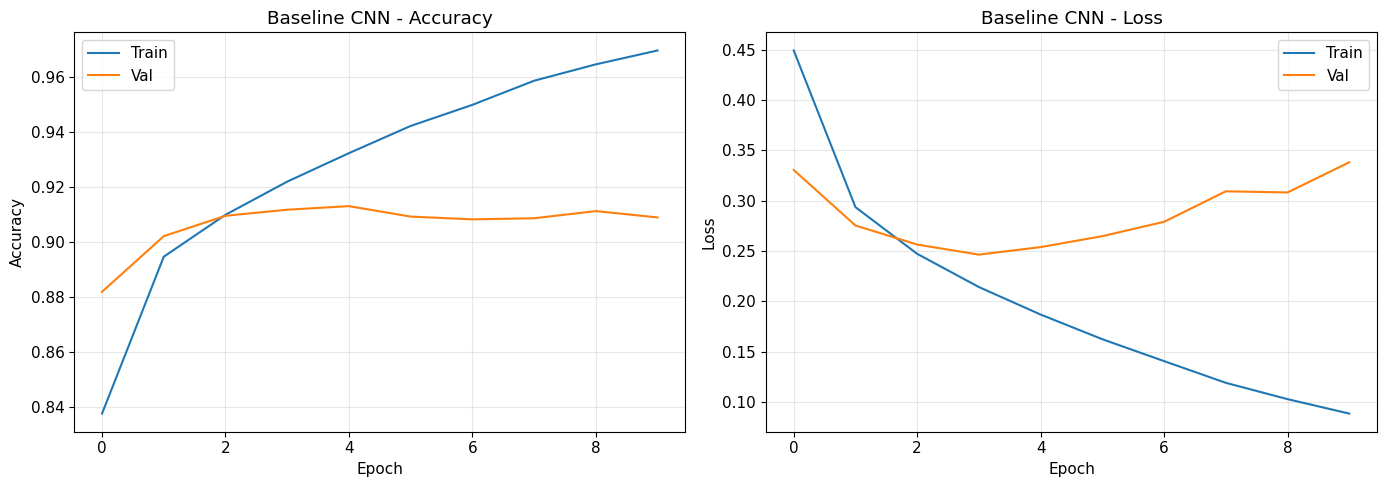

In [9]:
# Plot baseline training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))  # Two side-by-side plots

# --- Plot Accuracy ---
ax1.plot(baseline_history.history['accuracy'], label='Train')     # Training accuracy
ax1.plot(baseline_history.history['val_accuracy'], label='Val')   # Validation accuracy
ax1.set_title('Baseline CNN - Accuracy')                         # Title
ax1.set_xlabel('Epoch')                                           # X-axis
ax1.set_ylabel('Accuracy')                                        # Y-axis
ax1.legend()                                                      # Show legend
ax1.grid(True, alpha=0.3)                                         # Light grid

# --- Plot Loss ---
ax2.plot(baseline_history.history['loss'], label='Train')         # Training loss
ax2.plot(baseline_history.history['val_loss'], label='Val')       # Validation loss
ax2.set_title('Baseline CNN - Loss')                              # Title
ax2.set_xlabel('Epoch')                                           # X-axis
ax2.set_ylabel('Loss')                                            # Y-axis
ax2.legend()                                                      # Show legend
ax2.grid(True, alpha=0.3)                                         # Light grid

plt.tight_layout()                                                # Adjust spacing
plt.show()                                                        # Display

## 6. Data Augmentation

**Data augmentation** creates new training samples by applying random transformations:
- **Rotation**: Rotate image up to 10 degrees
- **Shift**: Move image horizontally/vertically by 10%
- **Zoom**: Zoom in/out by 10%
- **Horizontal flip**: Mirror the image

This helps the model generalize better by seeing more variations of each image.

**Important**: Augmentation is applied only during training, NOT during validation or testing.


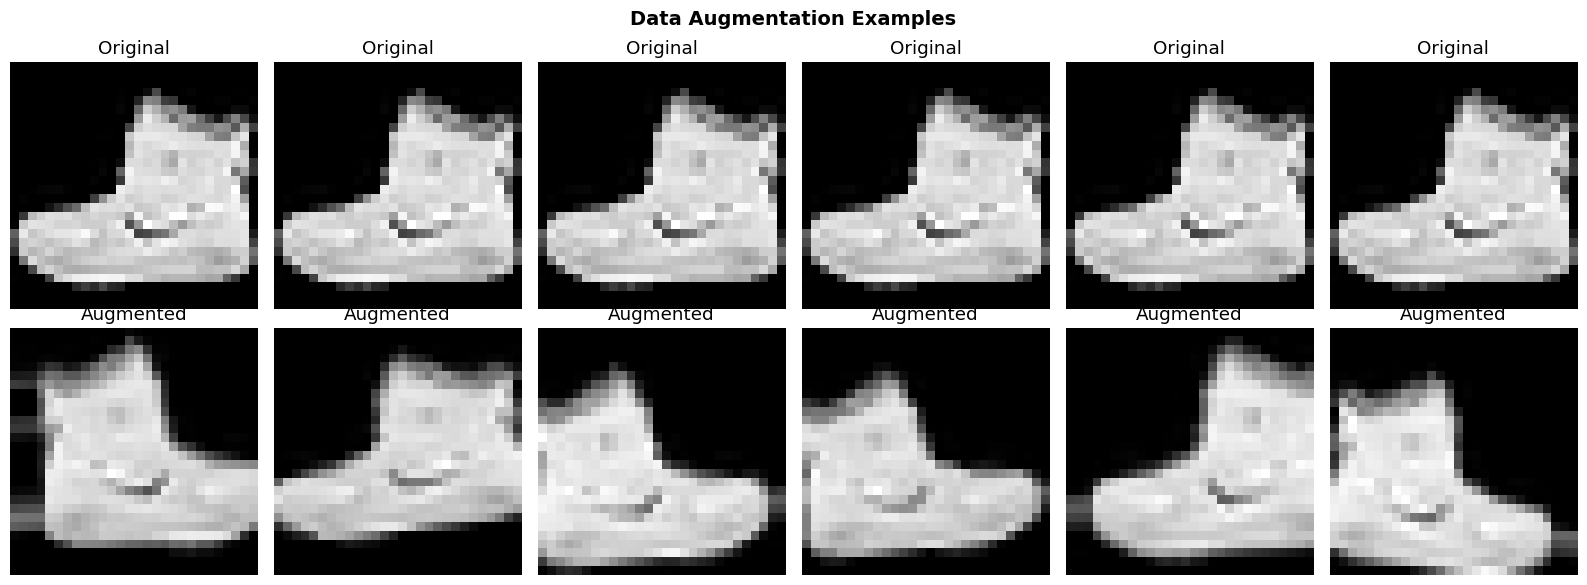

In [10]:
# Create an augmentation generator
datagen = ImageDataGenerator(
    rotation_range=10,       # Rotate up to 10 degrees
    width_shift_range=0.1,   # Shift horizontally by up to 10%
    height_shift_range=0.1,  # Shift vertically by up to 10%
    zoom_range=0.1,          # Zoom in/out by up to 10%
    horizontal_flip=True     # Randomly flip horizontally
)

# Visualize augmented samples
fig, axes = plt.subplots(2, 6, figsize=(16, 6))   # 2 rows: original + augmented
sample_img = X_train_split[0:1]                    # Take first image (keep batch dim)

# Row 1: Show original image 6 times for reference
for ax in axes[0]:
    ax.imshow(sample_img[0, :, :, 0], cmap='gray') # Show original
    ax.set_title('Original')                        # Label
    ax.axis('off')                                  # Hide axes

# Row 2: Show 6 different augmented versions
aug_iter = datagen.flow(sample_img, batch_size=1)   # Create augmentation iterator
for ax in axes[1]:
    aug_img = next(aug_iter)                         # Get next augmented image
    ax.imshow(aug_img[0, :, :, 0], cmap='gray')     # Show it
    ax.set_title('Augmented')                        # Label
    ax.axis('off')                                   # Hide axes

plt.suptitle('Data Augmentation Examples', fontsize=14, fontweight='bold')
plt.tight_layout()                                   # Adjust spacing
plt.show()                                           # Display


## 7. Improved CNN (BatchNorm + Dropout)

We improve the baseline by adding:
- **BatchNormalization**: Normalizes activations between layers, speeds up training
- **Dropout**: Randomly disables neurons during training to prevent overfitting
- **More conv layers**: Deeper network can learn more complex patterns

| Technique | What it Does | Benefit |
|---|---|---|
| BatchNorm | Normalizes layer outputs | Faster, more stable training |
| Dropout(0.25) | Drops 25% of neurons | Reduces overfitting |
| More layers | Deeper features | Learns complex patterns |


In [11]:
# Build an improved CNN with BatchNorm and Dropout
improved_model = models.Sequential([               # Stack layers in sequence
    # --- Conv Block 1 ---
    layers.Conv2D(32, (3, 3),                      # 32 filters, 3x3 kernel
                  activation='relu',               # ReLU activation
                  padding='same',                  # Preserve spatial size
                  input_shape=(28, 28, 1)),        # Input shape
    layers.BatchNormalization(),                    # Normalize activations
    layers.Conv2D(32, (3, 3),                      # Another 32 filters
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D((2, 2)),                   # Downsample: 28->14
    layers.Dropout(0.25),                          # Drop 25% of neurons

    # --- Conv Block 2 ---
    layers.Conv2D(64, (3, 3),                      # 64 filters
                  activation='relu',
                  padding='same'),
    layers.BatchNormalization(),                    # Normalize activations
    layers.Conv2D(64, (3, 3),                      # Another 64 filters
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D((2, 2)),                   # Downsample: 14->7
    layers.Dropout(0.25),                          # Drop 25% of neurons

    # --- Classifier ---
    layers.Flatten(),                              # Flatten feature maps
    layers.Dense(128, activation='relu'),          # Dense layer: 128 units
    layers.Dropout(0.5),                           # Drop 50% before output
    layers.Dense(10, activation='softmax')         # Output: 10 classes
])

# Compile the model
improved_model.compile(
    optimizer='adam',                              # Adam optimizer
    loss='sparse_categorical_crossentropy',        # For integer labels
    metrics=['accuracy']                           # Track accuracy
)

# Show model summary
improved_model.summary()                           # Print architecture

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 468,202 (1.79 MB)

 Trainable params: 468,010 (1.79 MB)

 Non-trainable params: 192 (768.00 B)

In [12]:
# Train the improved model WITH data augmentation
print('Training improved CNN with augmentation...')

# Fit the augmentation generator to our training data
datagen.fit(X_train_split)                         # Compute stats for augmentation

# Train using augmented data
improved_history = improved_model.fit(
    datagen.flow(X_train_split, y_train_split,     # Augmented training data
                 batch_size=64),                    # 64 samples per batch
    epochs=15,                                     # Train for 15 epochs
    validation_data=(X_val, y_val),                # Validation data (NOT augmented)
    verbose=1                                      # Show progress
)

# Evaluate on test set
improved_acc = improved_model.evaluate(X_test, y_test, verbose=0)[1]  # Test accuracy
print(f'\nImproved CNN Test Accuracy: {improved_acc:.4f}')  # Print result


Training improved CNN with augmentation...
Epoch 1/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 31ms/step - accuracy: 0.4980 - loss: 1.3968 - val_accuracy: 0.7734 - val_loss: 0.5812
Epoch 2/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.6990 - loss: 0.7884 - val_accuracy: 0.8039 - val_loss: 0.5359
Epoch 3/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.7501 - loss: 0.6563 - val_accuracy: 0.8366 - val_loss: 0.4217
Epoch 4/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.7838 - loss: 0.5849 - val_accuracy: 0.8603 - val_loss: 0.3799
Epoch 5/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.8112 - loss: 0.5163 - val_accuracy: 0.8780 - val_loss: 0.3374
Epoch 6/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.8254 - loss: 0.4808 - val_accuracy: 0.8762 - val_loss: 0.3480
Epoch 7/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.8379 - loss: 0.4537 - val_accuracy: 0.8871 - val_loss: 0.3068
Epoch 8/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 19s 24m

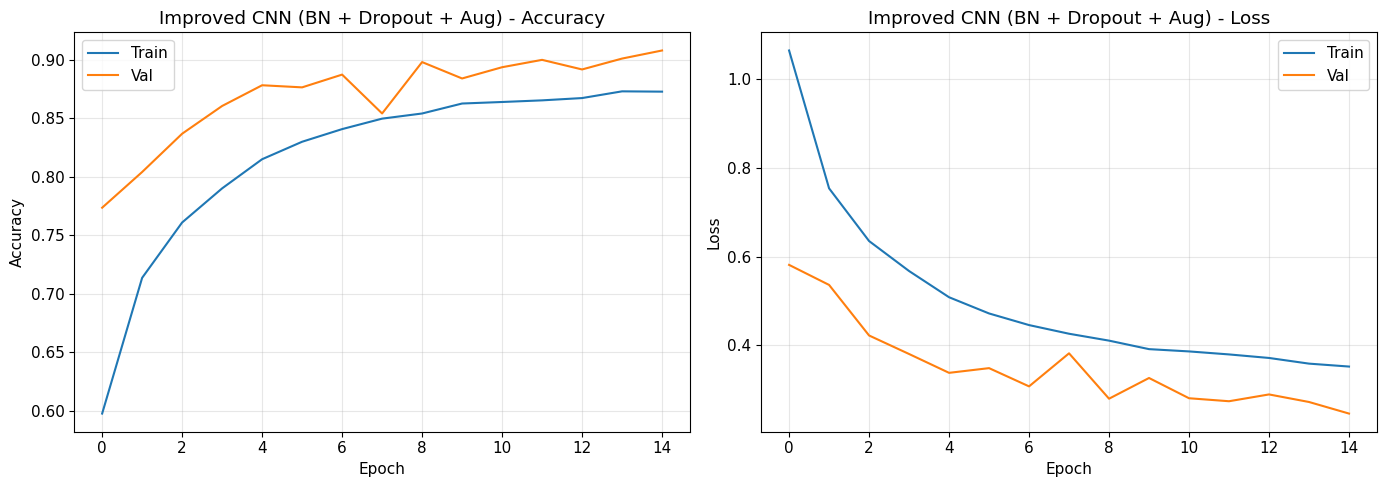

In [13]:
# Plot improved model training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))  # Two side-by-side plots

# --- Plot Accuracy ---
ax1.plot(improved_history.history['accuracy'], label='Train')     # Training accuracy
ax1.plot(improved_history.history['val_accuracy'], label='Val')   # Validation accuracy
ax1.set_title('Improved CNN (BN + Dropout + Aug) - Accuracy')    # Title
ax1.set_xlabel('Epoch')                                           # X-axis
ax1.set_ylabel('Accuracy')                                        # Y-axis
ax1.legend()                                                      # Show legend
ax1.grid(True, alpha=0.3)                                         # Light grid

# --- Plot Loss ---
ax2.plot(improved_history.history['loss'], label='Train')         # Training loss
ax2.plot(improved_history.history['val_loss'], label='Val')       # Validation loss
ax2.set_title('Improved CNN (BN + Dropout + Aug) - Loss')        # Title
ax2.set_xlabel('Epoch')                                           # X-axis
ax2.set_ylabel('Loss')                                            # Y-axis
ax2.legend()                                                      # Show legend
ax2.grid(True, alpha=0.3)                                         # Light grid

plt.tight_layout()                                                # Adjust spacing
plt.show()                                                        # Display

## 8. Learning Rate Scheduling

**Learning rate scheduling** adjusts the learning rate during training:

| Callback | What it Does |
|---|---|
| **ReduceLROnPlateau** | If validation loss stops improving for N epochs, reduce LR by a factor |
| **EarlyStopping** | Stop training if no improvement for N epochs (saves time) |

Starting with a higher LR helps learn fast, then reducing it helps fine-tune.


In [15]:
# Build a fresh improved model for LR scheduling experiment
lr_model = models.Sequential([                     # Same architecture as improved CNN
    # --- Conv Block 1 ---
    layers.Conv2D(32, (3, 3), activation='relu',
                  padding='same', input_shape=(28, 28, 1)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # --- Conv Block 2 ---
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # --- Classifier ---
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

# Compile
lr_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
my_callbacks = [
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',                        # Watch validation loss
        factor=0.5,                                # Halve the learning rate
        patience=3,                                # Wait 3 epochs before reducing
        min_lr=1e-6,                               # Don't go below 0.000001
        verbose=1                                  # Print when LR changes
    ),
    callbacks.EarlyStopping(
        monitor='val_loss',                        # Watch validation loss
        patience=7,                                # Stop if no improvement for 7 epochs
        restore_best_weights=True,                 # Keep the best model weights
        verbose=1                                  # Print when stopping
    )
]

# Train with callbacks
print('Training with LR scheduling...')
lr_history = lr_model.fit(
    datagen.flow(X_train_split, y_train_split,     # Augmented data
                 batch_size=64),
    epochs=10,                                     # Max 30 epochs (early stop likely)
    validation_data=(X_val, y_val),                # Validation data
    callbacks=my_callbacks,                        # Use our callbacks
    verbose=1                                      # Show progress
)

# Evaluate
lr_acc = lr_model.evaluate(X_test, y_test, verbose=0)[1]  # Test accuracy
print(f'\nLR Scheduled Model Test Accuracy: {lr_acc:.4f}')

Training with LR scheduling...
Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 31s 31ms/step - accuracy: 0.4924 - loss: 1.3846 - val_accuracy: 0.7665 - val_loss: 0.5905 - learning_rate: 0.0010
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.6814 - loss: 0.8065 - val_accuracy: 0.8275 - val_loss: 0.4639 - learning_rate: 0.0010
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.7360 - loss: 0.6872 - val_accuracy: 0.8081 - val_loss: 0.6002 - learning_rate: 0.0010
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.7795 - loss: 0.5938 - val_accuracy: 0.8513 - val_loss: 0.3997 - learning_rate: 0.0010
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.8041 - loss: 0.5321 - val_accuracy: 0.8710 - val_loss: 0.3729 - learning_rate: 0.0010
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.8236 - loss: 0.4925 - val_accuracy: 0.8821 - val_loss: 0.3132 - learning_rate: 0.0010
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 2

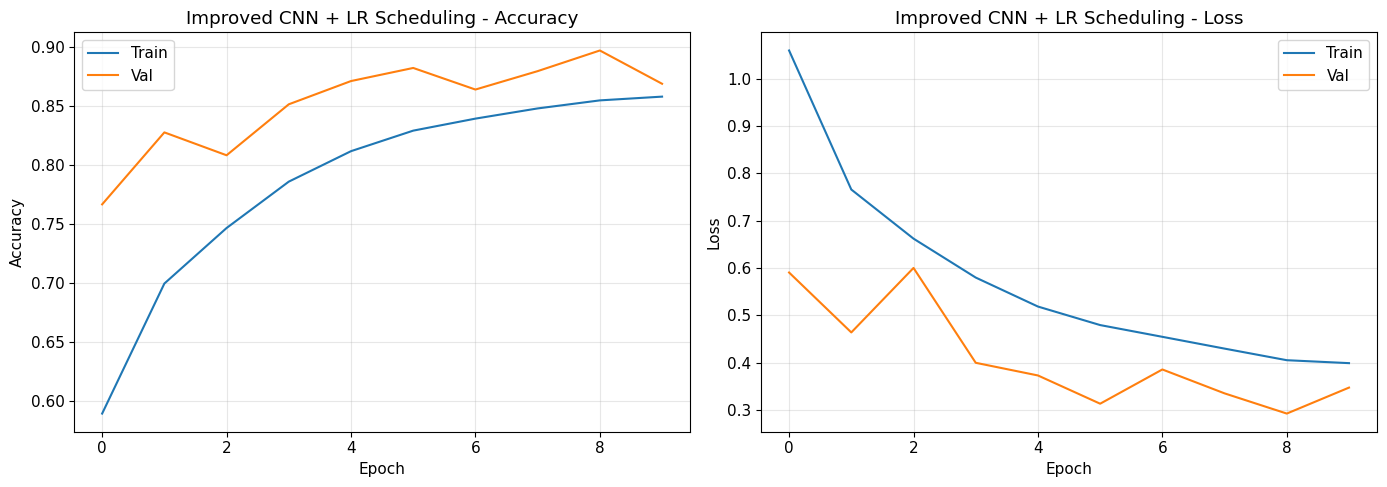

In [16]:
# Plot LR scheduled model training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))  # Two side-by-side plots

# --- Plot Accuracy ---
ax1.plot(lr_history.history['accuracy'], label='Train')           # Training accuracy
ax1.plot(lr_history.history['val_accuracy'], label='Val')         # Validation accuracy
ax1.set_title('Improved CNN + LR Scheduling - Accuracy')          # Title
ax1.set_xlabel('Epoch')                                           # X-axis
ax1.set_ylabel('Accuracy')                                        # Y-axis
ax1.legend()                                                      # Show legend
ax1.grid(True, alpha=0.3)                                         # Light grid

# --- Plot Loss ---
ax2.plot(lr_history.history['loss'], label='Train')               # Training loss
ax2.plot(lr_history.history['val_loss'], label='Val')             # Validation loss
ax2.set_title('Improved CNN + LR Scheduling - Loss')              # Title
ax2.set_xlabel('Epoch')                                           # X-axis
ax2.set_ylabel('Loss')                                            # Y-axis
ax2.legend()                                                      # Show legend
ax2.grid(True, alpha=0.3)                                         # Light grid

plt.tight_layout()                                                # Adjust spacing
plt.show()                                                        # Display

## 9. Filter & Feature Map Visualization

### What does the CNN actually learn?
- **Filters (weights)**: The 3x3 kernels the CNN learns to detect patterns
- **Feature maps**: What the input image looks like AFTER passing through a filter

Early layers learn **edges and textures**. Deeper layers learn **shapes and patterns**.


Filter shape: (3, 3, 1, 32)


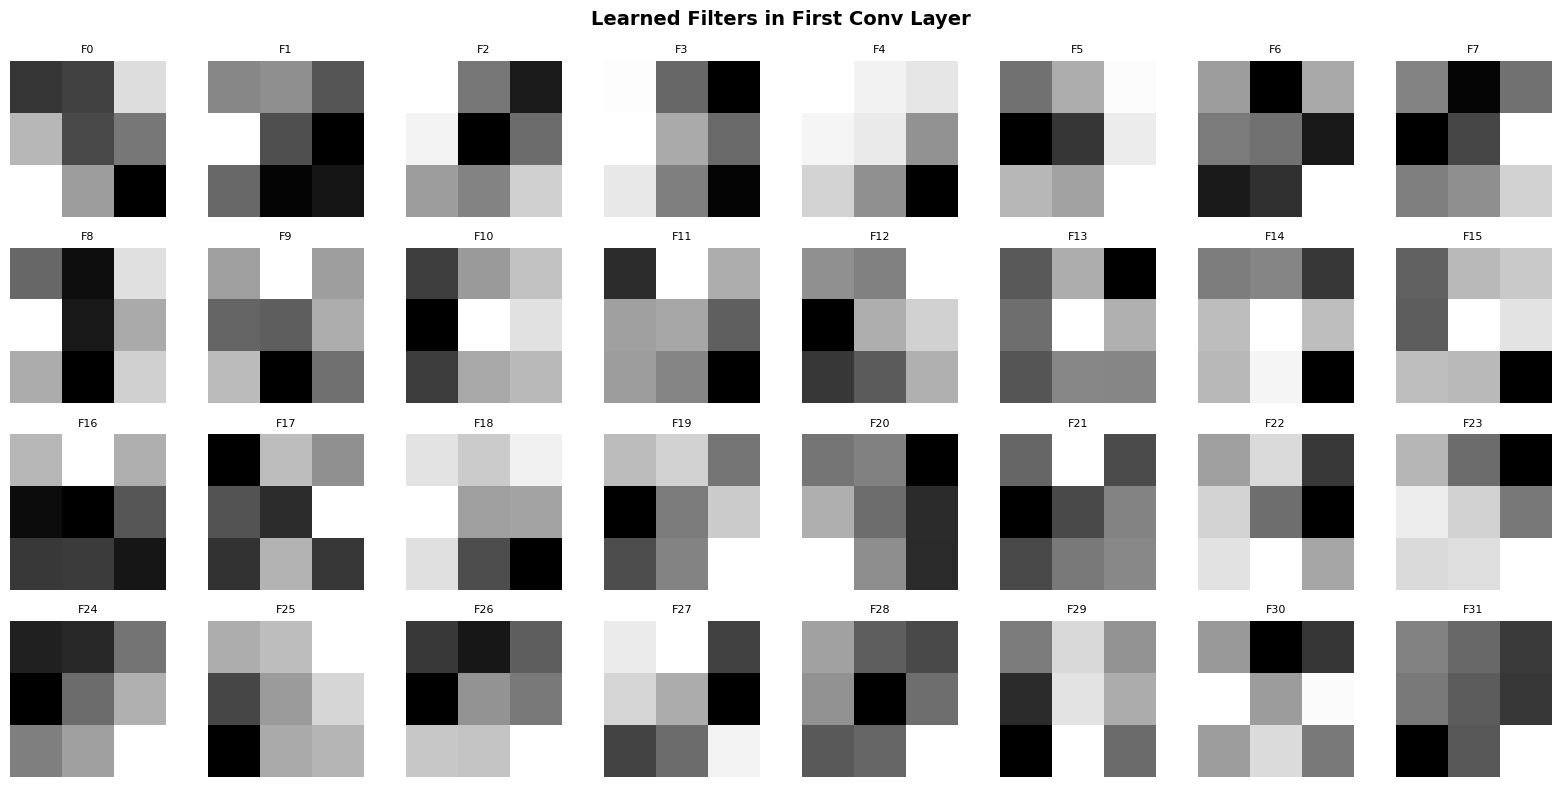

In [17]:
# Visualize the filters (weights) of the first convolutional layer
first_conv = lr_model.layers[0]                    # Get first Conv2D layer
filters = first_conv.get_weights()[0]              # Get filter weights

print(f'Filter shape: {filters.shape}')            # (3, 3, 1, 32) = 32 filters

# Plot all 32 filters
fig, axes = plt.subplots(4, 8, figsize=(16, 8))   # 4 rows x 8 columns = 32
for i, ax in enumerate(axes.flat):                 # Loop through 32 filters
    ax.imshow(filters[:, :, 0, i], cmap='gray')    # Show 3x3 filter
    ax.axis('off')                                 # Hide axes
    ax.set_title(f'F{i}', fontsize=8)              # Label each filter

plt.suptitle('Learned Filters in First Conv Layer', fontsize=14, fontweight='bold')
plt.tight_layout()                                 # Adjust spacing
plt.show()                                         # Display


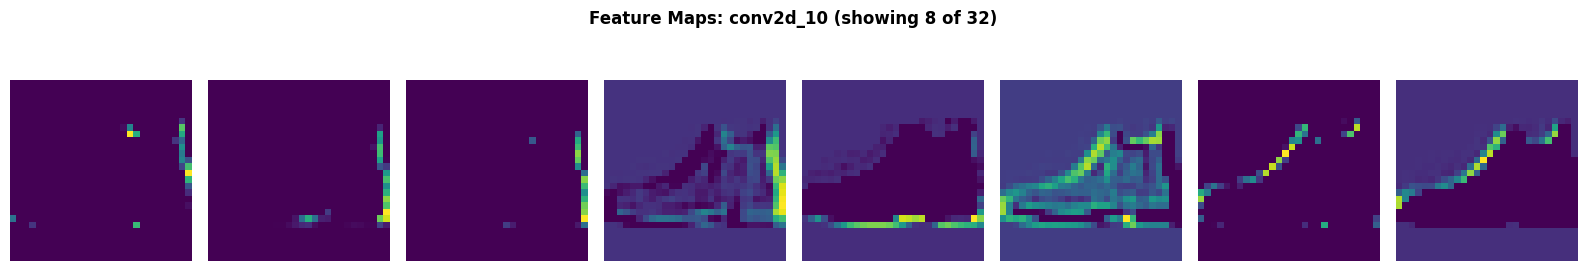

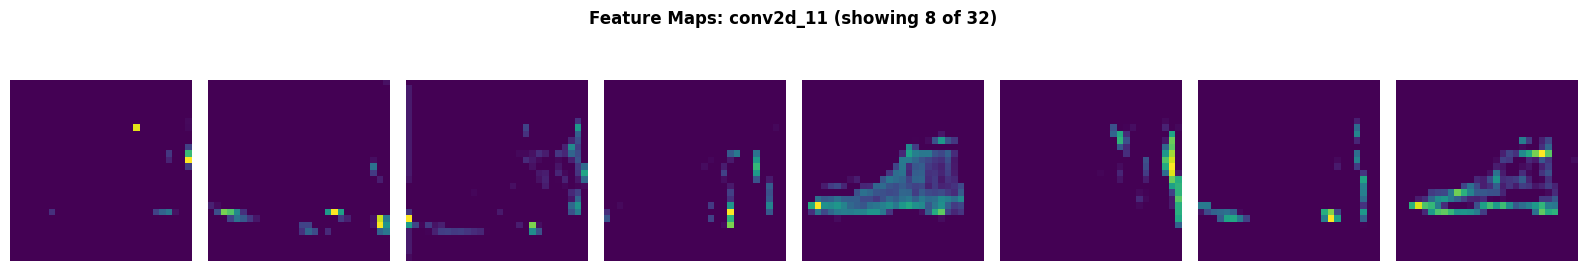

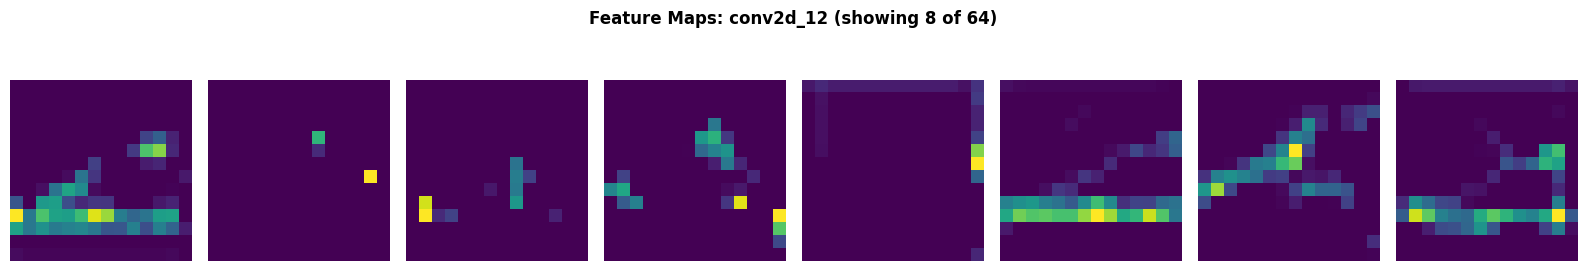

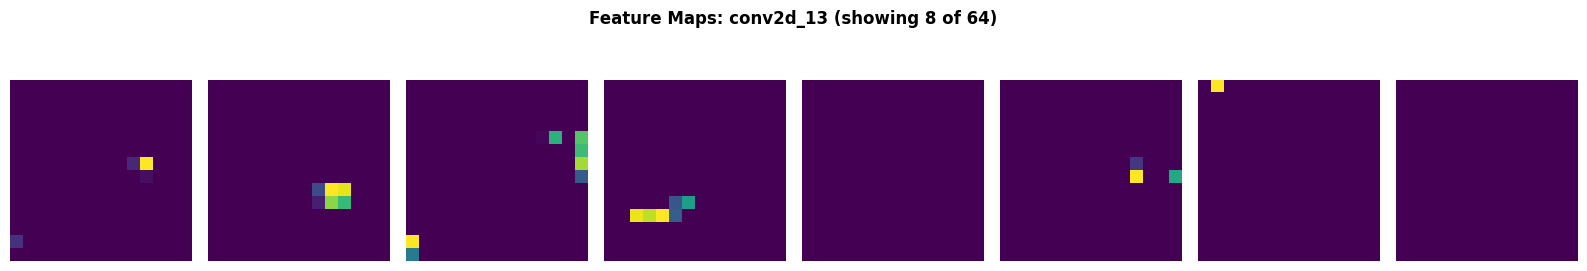

In [18]:
# Visualize feature maps for a sample image
sample = X_test[0:1]                               # Take first test image

# Ensure the model is built by running a prediction first
_ = lr_model.predict(sample, verbose=0)            # Build internal graph

# Get all conv layer names
conv_layer_names = [layer.name for layer in lr_model.layers
                    if 'conv2d' in layer.name]     # Find all conv layer names

# Build a feature extraction model using explicit Input layer
input_layer = layers.Input(shape=(28, 28, 1))      # Create explicit input
x = input_layer                                     # Start from input
layer_outputs = []                                   # Collect conv outputs

for layer in lr_model.layers:                        # Loop through all layers
    x = layer(x)                                     # Pass through each layer
    if 'conv2d' in layer.name:                       # If it's a conv layer
        layer_outputs.append(x)                      # Save its output

feature_model = models.Model(inputs=input_layer,    # Input tensor
                              outputs=layer_outputs) # All conv outputs

# Get feature maps for the sample image
feature_maps = feature_model.predict(sample, verbose=0)  # Get all feature maps

# Plot feature maps from each conv layer
for name, fmap in zip(conv_layer_names, feature_maps):
    n_filters = min(8, fmap.shape[-1])             # Show up to 8 filters
    fig, axes = plt.subplots(1, n_filters, figsize=(16, 3))  # One row

    for i in range(n_filters):                     # Loop through filters
        axes[i].imshow(fmap[0, :, :, i], cmap='viridis')  # Show feature map
        axes[i].axis('off')                        # Hide axes

    plt.suptitle(f'Feature Maps: {name} (showing {n_filters} of {fmap.shape[-1]})',
                 fontsize=12, fontweight='bold')
    plt.tight_layout()                             # Adjust spacing
    plt.show()                                     # Display

## 10. Model Comparison


Model                       Test Accuracy
  Baseline CNN                   0.9066
  Improved + Aug                 0.9037
  Improved + LR                  0.8896


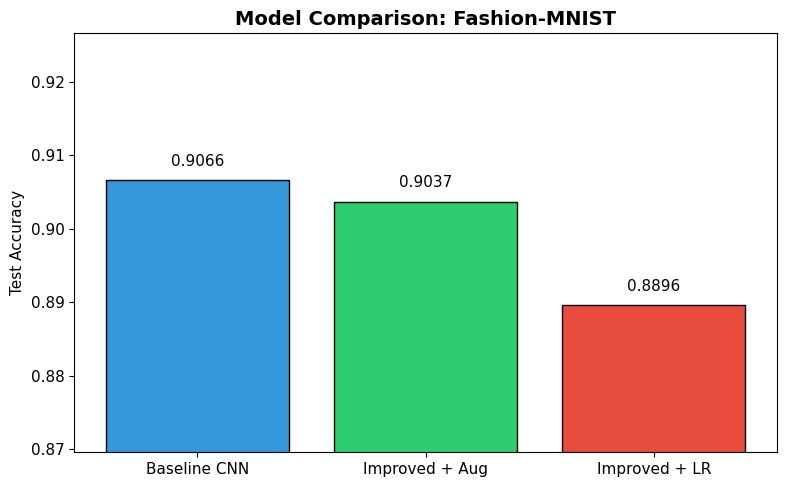

In [19]:
# Compare all three models
results = {
    'Baseline CNN': baseline_acc,                  # Simple CNN accuracy
    'Improved + Aug': improved_acc,                # BN + Dropout + Augmentation
    'Improved + LR': lr_acc                        # + Learning Rate Scheduling
}

# Print results table
print(f'{"Model":<25} {"Test Accuracy":>15}')
print('=' * 42)
for name, acc in results.items():
    print(f'  {name:<23} {acc:>13.4f}')           # Print each result

# Bar chart
plt.figure(figsize=(8, 5))                         # Set figure size
colors = ['#3498db', '#2ecc71', '#e74c3c']         # Blue, green, red
bars = plt.bar(results.keys(), results.values(),   # Create bars
               color=colors, edgecolor='black')    # Colored bars

# Add accuracy labels on each bar
for bar, acc in zip(bars, results.values()):
    plt.text(bar.get_x() + bar.get_width()/2,     # X position: center of bar
             acc + 0.002,                          # Y position: slightly above bar
             f'{acc:.4f}',                         # Text: accuracy value
             ha='center', fontsize=11)             # Center align

plt.ylabel('Test Accuracy')                        # Y-axis label
plt.title('Model Comparison: Fashion-MNIST', fontsize=14, fontweight='bold')
plt.ylim(min(results.values()) - 0.02,            # Y-axis lower bound
         max(results.values()) + 0.02)             # Y-axis upper bound
plt.tight_layout()                                 # Adjust spacing
plt.show()                                         # Display


## 11. Conclusion

### Key Takeaways

**Architecture:**
- A simple 2-layer CNN already achieves good accuracy on Fashion-MNIST
- Adding BatchNormalization and Dropout improves both accuracy and generalization

**Data Augmentation:**
- Random rotations, shifts, and flips create more training variety
- Helps the model generalize to unseen data
- Only applied during training (not validation/test)

**Learning Rate Scheduling:**
- ReduceLROnPlateau dynamically lowers the learning rate when progress stalls
- EarlyStopping prevents wasting time on unnecessary epochs

**Visualization Insights:**
- First layer filters detect edges and simple textures
- Deeper layers capture more complex patterns like shapes and object parts

### Progression Path
| Step | Technique | Purpose |
|---|---|---|
| 1 | Baseline CNN | Establish reference accuracy |
| 2 | + BatchNorm + Dropout | Regularization |
| 3 | + Data Augmentation | More training variety |
| 4 | + LR Scheduling | Better convergence |
